# 数据预处理与特征工程

当数据预处理完成后，我们就要开始进行特征工程了。

|特征提取(feature extraction) | 特征创造(feature creation) | 特征选择(feature selection) |
| :------ | :----- | :----- |
| 从文字，图像，声音等其他非结构化数据中提取新信息作为特征。比如说，从淘宝宝贝的名称中提取出产品类别，产品颜色，是否是网红产品等等。 | 把现有特征进行组合，或互相计算，得到新的特征。比如说，我们有一列特征是速度，一列特征是距离，我们就可以通过让两列相处，创造新的特征：通过距离所花的时间。 | 从所有的特征中，选择出有意义，对模型有帮助的特征，以避免必须将所有特征都导入模型去训练的情况 |

## 3、特征选择

在做特征选择之前，有三件非常重要的事：**跟数据提供者开会！跟数据提供者开会！跟数据提供者开会！**

一定要抓住给你提供数据的人，尤其是理解业务和数据含义的人，跟他们聊一段时间。技术能够让模型起飞，前提
是你和业务人员一样理解数据。所以特征选择的第一步，其实是根据我们的目标，用业务常识来选择特征。来看完
整版泰坦尼克号数据中的这些特征：

![](../imgs/features_select_example.png)

其中是否存活是我们的标签。很明显，以判断“是否存活”为目的，票号，登船的舱门，乘客编号明显是无关特征，
可以直接删除。姓名也基本可以判断是相关性比较低的特征。性别，年龄，船上的亲人数量，舱位等级，船舱编号，这些应该是相关性比较高的特征。

**所以，特征工程的第一步是：理解业务。**

当然了，在真正的数据应用领域，比如金融，医疗，电商，我们的数据不可能像泰坦尼克号数据的特征这样少，这样明显，那如果遇见极端情况，我们无法依赖对业务的理解来选择特征，该怎么办呢？我们有四种方法可以用来选择特征：过滤法，嵌入法，包装法，和降维算法。

In [35]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectFromModel, RFE
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 手写数字识别数据
# 这个数据量相对夸张，如果使用支持向量机和神经网络，很可能会直接跑不出来。使用KNN跑一次大概需要半个小时。
# 用这个数据举例，能更够体现特征工程的重要性。

data = pd.read_csv("../data/digit recognizor.csv")
x = data.iloc[:, 1:]
y = data.iloc[:, 0]
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
x.shape

(42000, 784)

### 3.1、Filter过滤法

过滤方法通常用作预处理步骤，特征选择完全独立于任何机器学习算法。它是根据各种统计检验中的分数以及相关
性的各项指标来选择特征。

![](../imgs/features_filter.png)

#### 3.1.1、方差过滤

##### 3.1.1.1、VarianceThreshold

   这是通过特征本身的方差来筛选特征的类。比如一个特征本身的方差很小，就表示样本在这个特征上基本没有差异，可能特征中的大多数值都一样，甚至整个特征的取值都相同，那这个特征对于样本区分没有什么作用。**所以无论接下来的特征工程要做什么，都要优先消除方差为0的特征。**VarianceThreshold有重要参数**threshold**，表示方差的阈值，表示舍弃所有方差小于threshold的特征，不填默认为0，即删除所有的记录都相同的特征。

In [13]:
x_var0 = VarianceThreshold().fit_transform(x)
x_var0.shape

(42000, 708)

可以看见，我们已经删除了方差为0的特征，但是依然剩下了708多个特征，明显还需要进一步的特征选择。然而，如果我们知道我们需要多少个特征，方差也可以帮助我们将特征选择一步到位。比如说，我们希望留下一半的特征，那可以设定一个让特征总数减半的方差阈值，只要找到特征方差的中位数，再将这个中位数作为参数threshold的值输入就好了：

In [14]:
# 原始数据的方差中位数
np.median(x.var().values)

1352.286703180131

In [16]:
# 方差比这个threshold阈值小的都剔除，所以你也可以找前100（任意大小）的方差设置
x_fsvar = VarianceThreshold(np.median(x.var().values)).fit_transform(x)
x_fsvar.shape

(42000, 392)

当特征是二分类时，特征的取值就是伯努利随机变量，这些变量的方差可以计算为：

![](../imgs/Bernoulli_distribution.png)

其中X是特征矩阵，p是二分类特征中的一类在这个特征中所占的概率。

In [17]:
# 若特征是伯努利随机变量，假设p=0.8，即二分类特征中某种分类占到80%以上的时候删除特征
x_bvar = VarianceThreshold(.8 * (1 - .8)).fit_transform(x)
x_bvar.shape

(42000, 685)

##### **3.1.1.2、方差过滤对模型的影响**

**我们这样做了以后，对模型效果会有怎样的影响呢？**在这里，准备了KNN和随机森林分别在方差过滤前和方差过滤后运行的效果和运行时间的对比。KNN是K近邻算法中的分类算法，其原理非常简单，是利用每个样本到其他样本点的距离来判断每个样本点的相似度，然后对样本进行分类。KNN必须遍历每个特征和每个样本，因而特征越多，KNN的计算也就会越缓慢。由于这一段代码对比运行时间过长，所以我贴出了代码和结果。

- **1. 导入模块并准备数据**

```python
# KNN vs 随机森林在不同方差过滤效果下的对比
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score
import numpy as np
X = data.iloc[:,1:]
y = data.iloc[:,0]

x_fsvar = VarianceThreshold(np.median(X.var().values)).fit_transform(X)
```

    我们从模块neighbors导入KNeighborsClassfier缩写为KNN，导入随机森林缩写为RFC，然后导入交叉验证模块和
numpy。其中未过滤的数据是X和y，使用中位数过滤后的数据是X_fsvar，都是我们之前已经运行过的代码。

- **2. KNN方差过滤前**

    - 代码
        ```python
        # ======【TIME WARNING：35mins +】======#
        cross_val_score(KNN(),X,y,cv=5).mean()
        # python中的魔法命令，可以直接使用%%timeit来计算运行这个cell中的代码所需的时间
        # 为了计算所需的时间，需要将这个cell中的代码运行很多次（通常是7次）后求平均值，因此运行%%timeit的时间会远远超过cell中的代码单独运行的时间
        # ======【TIME WARNING：4 hours】======#
        %%timeit
        cross_val_score(KNN(),X,y,cv=5).mean()
        ```
    - 结果

        ![](../imgs/knn_filter_before.png)


- **3. KNN方差过滤后**

    - 代码
        ```python

            # ======【TIME WARNING：20 mins+】======#
            cross_val_score(KNN(),X_fsvar,y,cv=5).mean()
            # ======【TIME WARNING：2 hours】======#
            %%timeit
            cross_val_score(KNN(),X,y,cv=5).mean()

        ```
    
    - 结果
    
        ![](../imgs/knn_filter_after.png)

    可以看出，对于KNN，过滤后的效果十分明显：准确率稍有提升，但平均运行时间减少了10分钟，特征选择过后算法的效率上升了1/3。那随机森林又如何呢？

- **4. 随机森林方差过滤前**
    
    - 代码
    ```python
        cross_val_score(RFC(n_estimators=10,random_state=0),X,y,cv=5).mean()
    ```
    
    - 结果
    
        ![](../imgs/randomforest_filter_before.png)

- **5. 随机森林方差过滤后**
    
    - 代码
    ```python
        cross_val_score(RFC(n_estimators=10,random_state=0),X_fsvar,y,cv=5).mean()
    ```
    
    - 结果
    
        ![](../imgs/randomforest_filter_after.png)

首先可以观察到的是，随机森林的准确率略逊于KNN，但运行时间却连KNN的1%都不到，只需要十几秒钟。其次，方差过滤后，随机森林的准确率也微弱上升，但运行时间却几乎是没什么变化，依然是11秒钟。

**为什么随机森林运行如此之快？为什么方差过滤对随机森林没很大的有影响？**这是由于两种算法的原理中涉及到的
计算量不同。最近邻算法KNN，单棵决策树，支持向量机SVM，神经网络，回归算法，都需要遍历特征或升维来进行运算，所以他们本身的运算量就很大，需要的时间就很长，因此方差过滤这样的特征选择对他们来说就尤为重要。但对于不需要遍历特征的算法，比如随机森林，它随机选取特征进行分枝，本身运算就非常快速，因此特征选择对它来说效果平平。这其实很容易理解，无论过滤法如何降低特征的数量，随机森林也只会选取固定数量的特征来建模；而最近邻算法就不同了，特征越少，距离计算的维度就越少，模型明显会随着特征的减少变得轻量。因此，过滤法的**主要对象**是：**需要遍历特征或升维的算法们**，而过滤法的**主要目的**是：**在维持算法表现的前提下，帮助算法们降低计算成本**

**思考：过滤法对随机森林无效，却对树模型有效？**

从算法原理上来说，传统决策树需要遍历所有特征，计算不纯度后进行分枝，而随机森林却是随机选择特征进行计算和分枝，因此随机森林的运算更快，过滤法对随机森林无用，对决策树却有用

在sklearn中，决策树和随机森林都是随机选择特征进行分枝（不记得的小伙伴可以去复习第一章：决策树，参数random_state），但决策树在建模过程中随机抽取的特征数目却远远超过随机森林当中每棵树随机抽取的特征数目（比如说对于这个780维的数据，随机森林每棵树只会抽取10-20个特征，而决策树可能会抽取300-400个特征），因此，过滤法对随机森林无用，却对决策树有用

也因此，在sklearn中，随机森林中的每棵树都比单独的一棵决策树简单得多，高维数据下的随机森林的计算比决策树快很多。

对受影响的算法来说，我们可以将方差过滤的影响总结如下：

| | 阈值很小<br>被过滤掉得特征比较少 | 阈值比较大<br>被过滤掉的特征有很多 |
| :------ | :----- | :----- |
| 模型表现 | 不会有太大影响 | 可能变更好，代表被滤掉的特征大部分是噪音<br>也可能变糟糕，代表被滤掉的特征中很多都是有效特征 |
| 运行时间 | 可能降低模型的运行时间<br>基于方差很小的特征有多少<br>当方差很小的特征不多时<br>对模型没有太大影响 | 一定能够降低模型的运行时间<br>算法在遍历特征时的计算越复杂，运行时间下降得越多 |

在我们的对比当中，我们使用的方差阈值是特征方差的中位数，因此属于阈值比较大，过滤掉的特征比较多的情
况。我们可以观察到，无论是KNN还是随机森林，在过滤掉一半特征之后，模型的精确度都上升了。这说明被我们
过滤掉的特征在当前随机模式(random_state = 0)下大部分是噪音。那我们就可以保留这个去掉了一半特征的数
据，来为之后的特征选择做准备。当然，如果过滤之后模型的效果反而变差了，我们就可以认为，被我们过滤掉的
特征中有很多都有有效特征，那我们就放弃过滤，使用其他手段来进行特征选择。

**思考：虽然随机森林算得快，但KNN的效果比随机森林更好？**

调整一下n_estimators试试看吧O(∩_∩)O，随机森林是个非常强大的模型哦~

- 调参：n_estimators

0.9655717345313324 151


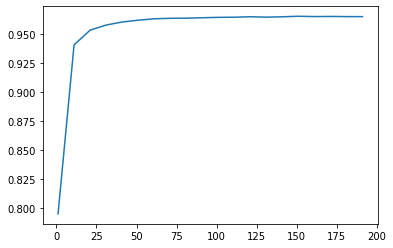

In [23]:
# 随机森林调参
# 方差过滤对随机森林影响不大，所以使用原数据
# x_fsvar = VarianceThreshold(np.median(x.var().values)).fit_transform(x)
scorel = []
for i in range(0, 200, 10):
    score = cross_val_score(RFC(n_estimators=i+1,random_state=5),x,y,cv=5).mean()
    scorel.append(score)
    
print(max(scorel), scorel.index(max(scorel)) * 10 + 1)

plt.plot(range(1, 201, 10), scorel)
plt.show()

0.9657146115178253 150


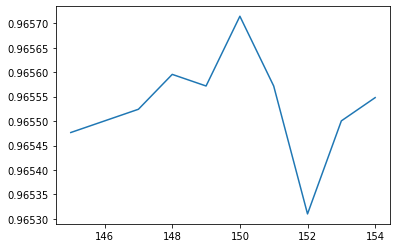

In [31]:
scorel = []
for i in range(145, 155):
    score = cross_val_score(RFC(n_estimators=i,random_state=5),x,y,cv=5).mean()
    scorel.append(score)
print(max(scorel), [*range(145,155)][scorel.index(max(scorel))])
plt.plot(range(145, 155), scorel)
plt.show()

- 调参：max_depth

0.9657146115178253 45


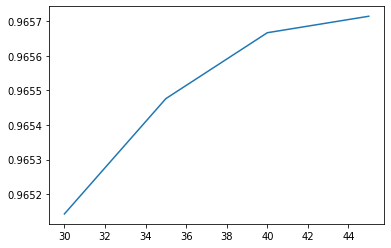

In [38]:
scorel = []
for i in range(30,50,5):
    score = cross_val_score(RFC(n_estimators=150,random_state=5, max_depth=i),x,y,cv=5).mean()
    scorel.append(score)
print(max(scorel), [*range(30,50,5)][scorel.index(max(scorel))])
plt.plot(range(30,50,5), scorel)
plt.show()

0.9657146115178253 45


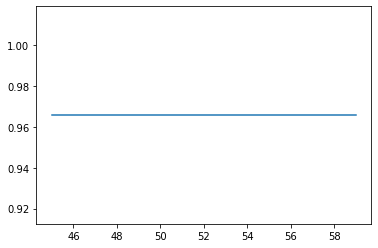

In [43]:
scorel = []
for i in range(45,60,2):
    score = cross_val_score(RFC(n_estimators=150,random_state=5, max_depth=i),x,y,cv=5).mean()
    scorel.append(score)
print(max(scorel), [*range(45,60,2)][scorel.index(max(scorel))])
plt.plot(range(45,60,2), scorel)
plt.show()

n_estimators调参后精确度明显上升，而max_depth调参后没有变化，所以仅仅调n_estimators就可以了，精确度跟KNN相差不大

##### 3.1.1.3、选取超参数threshold

**我们怎样知道，方差过滤掉的到底时噪音还是有效特征呢？**过滤后模型到底会变好还是会变坏呢？答案是：每个数
据集不一样，只能自己去尝试。这里的方差阈值，其实相当于是一个超参数，要选定最优的超参数，我们可以画学
习曲线，找模型效果最好的点。但现实中，我们往往不会这样去做，因为这样会耗费大量的时间。我们只会使用阈
值为0或者阈值很小的方差过滤，来为我们优先消除一些明显用不到的特征，然后我们会选择更优的特征选择方法
继续削减特征数量。

#### 3.1.2、相关性过滤

方差挑选完毕之后，我们就要考虑下一个问题：相关性了。我们希望选出与标签相关且有意义的特征，因为这样的
特征能够为我们提供大量信息。如果特征与标签无关，那只会白白浪费我们的计算内存，可能还会给模型带来噪
音。在sklearn当中，我们有三种常用的方法来评判特征与标签之间的相关性：卡方，F检验，互信息。

##### 3.1.2.1、卡方过滤

卡方过滤是专门针对离散型标签（即分类问题）的相关性过滤。卡方检验类**feature_selection.chi2**计算每个非负特征和标签之间的卡方统计量，并依照卡方统计量由高到低为特征排名。再结合**feature_selection.SelectKBest**这个可以输入”评分标准“来选出前K个分数最高的特征的类，我们可以借此除去最可能独立于标签，与我们分类目的无关的特征。

另外，如果卡方检验检测到某个特征中所有的值都相同，会提示我们使用方差先进行方差过滤。并且，刚才我们已经验证过，当我们使用方差过滤筛选掉一半的特征后，模型的表现时提升的。因此在这里，我们使用threshold=中位数时完成的方差过滤的数据来做卡方检验（如果方差过滤后模型的表现反而降低了，那我们就不会使用方差过滤后的数据，而是使用原数据）：

In [47]:
# 假设在这里我已知我需要300个特征
x_fschi = SelectKBest(chi2, k=300).fit_transform(x_fsvar, y)
x_fschi.shape

(42000, 300)

In [48]:
# 验证一下模型的效果如何：
cross_val_score(RFC(n_estimators=150, random_state=5), x_fschi, y, cv=5).mean()

0.9610479638992206

可以看出，模型的效果降低了，这说明我们在设定k=300的时候删除了与模型相关且有效的特征，我们的K值设置得太小，要么我们需要调整K值，要么我们必须放弃相关性过滤。当然，如果模型的表现提升，则说明我们的相关性过滤是有效的，是过滤掉了模型的噪音的，这时候我们就保留相关性过滤的结果。

##### 3.1.2.2、选取超参数K

那如何设置一个最佳的K值呢？在现实数据中，数据量很大，模型很复杂的时候，我们也许不能先去跑一遍模型看看效果，而是希望最开始就能够选择一个最优的超参数k。那第一个方法，就是我们之前提过的学习曲线：

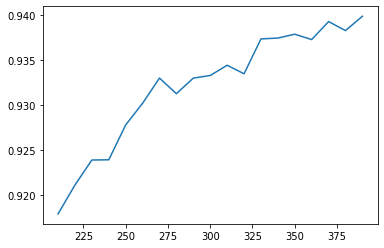

In [56]:
#======【TIME WARNING: 5 mins】======#

score = []
for i in range(390,200,-10):
    x_fschi = SelectKBest(chi2, k=i).fit_transform(x_fsvar, y)
    # 这里就不使用150颗树了，使用上面图片示例里的值对比
    once = cross_val_score(RFC(n_estimators=10,random_state=0),x_fschi,y,cv=5).mean()
    score.append(once)
plt.plot(range(390,200,-10),score)
plt.show()

通过这条曲线，我们可以观察到，随着K值的不断增加，模型的表现不断上升，这说明，K越大越好，数据中所有的特征都是与标签相关的。但是运行这条曲线的时间同样也是非常地长，接下来我们就来介绍一种更好的选择k的方法：**看p值选择k**。

卡方检验的本质是推测两组数据之间的差异，其检验的原假设是”两组数据是相互独立的”。卡方检验返回卡方值和P值两个统计量，其中卡方值很难界定有效的范围，而p值，我们一般使用0.01或0.05作为显著性水平，即p值判断的边界，具体我们可以这样来看：


| P值 | <=0.05或0.01 | >0.05或0.01 |
| :------ | :----- | :----- |
| 数据差异 | 差异不是自然形成的 | 这些差异是很自然的样本误差 |
| 相关性 | 两组数据是相关的 | 两组数据是相互独立的 |
| 原假设 | 拒绝原假设，接受备择假设 | 接受原假设 |

从特征工程的角度，我们希望选取卡方值很大，p值小于0.05的特征，即和标签是相关联的特征。而调用SelectKBest之前，我们可以直接从chi2实例化后的模型中获得各个特征所对应的卡方值和P值。

In [58]:
chivalue, pvalues_chi = chi2(x_fsvar, y)
chivalue[:10]

array([ 945664.84392643, 1244766.05139164, 1554872.30384525,
       1834161.78305343, 1903618.94085294, 1845226.62427198,
       1602117.23307537,  708535.17489837,  974050.20513718,
       1188092.19961931])

In [59]:
pvalues_chi

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [65]:
# k取多少？我们想要消除所有p值大于设定值，比如0.05或0.01的特征：
k = chivalue.shape[0] - (pvalues_chi > 0.05).sum()
k2 = (pvalues_chi <= 0.05).sum()
print(x_fsvar.shape, k, k2, sep='\n'*2)

(42000, 392)

392

392


In [66]:
# 现在我们知道了具体的k
x_fschi = SelectKBest(chi2, k=392).fit_transform(x_fsvar, y)
cross_val_score(RFC(n_estimators=10, random_state=0), x_fschi, y, cv=5).mean()

0.9388098166696807

可以观察到，所有特征的p值都是0，这说明对于digit recognizor这个数据集来说，方差验证已经把所有和标签无关的特征都剔除了，或者这个数据集本身就不含与标签无关的特征。在这种情况下，舍弃任何一个特征，都会舍弃对模型有用的信息，而使模型表现下降，因此在我们对计算速度感到满意时，我们不需要使用相关性过滤来过滤我们的数据。如果我们认为运算速度太缓慢，那我们可以酌情删除一些特征，但前提是，我们必须牺牲模型的表现。接下来，我们试试看用其他的相关性过滤方法验证一下我们在这个数据集上的结论。

##### 3.1.2.3、F检验

F检验，又称ANOVA，方差齐性检验，是用来捕捉每个特征与标签之间的线性关系的过滤方法。它即可以做回归也可以做分类，因此包含**feature_selection.f_classif**（F检验分类）和**feature_selection.f_regression**（F检验回归）两个类。其中F检验分类用于标签是离散型变量的数据，而F检验回归用于标签是连续型变量的数据。

和卡方检验一样，这两个类需要和类SelectKBest连用，并且我们也可以直接通过输出的统计量来判断我们到底要设置一个什么样的K。需要注意的是，F检验在数据服从正态分布时效果会非常稳定，因此如果使用F检验过滤，我们会先将数据转换成服从正态分布的方式。

F检验的本质是寻找两组数据之间的线性关系，其原假设是”数据不存在显著的线性关系“。它返回F值和p值两个统计量。和卡方过滤一样，**我们希望选取p值小于0.05或0.01的特征，这些特征与标签时显著线性相关的**，而p值大于0.05或0.01的特征则被我们认为是和标签没有显著线性关系的特征，应该被删除。以F检验的分类为例，我们继续在数字数据集上来进行特征选择

In [69]:
F, pvalues_f = f_classif(x_fsvar, y)
F[:10]

array([ 618.65383492,  846.18897012, 1115.40617051, 1362.3677305 ,
       1452.03355369, 1381.09095571, 1138.26505266,  464.29616121,
        660.00977785,  849.66393412])

In [73]:
pvalues_f[:25]

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 4.71193533e-220,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000])

In [75]:
k = (pvalues_f <= 0.05).sum()  # 还是392
x_fsF = SelectKBest(f_classif, k=k).fit_transform(x_fsvar, y)
cross_val_score(RFC(n_estimators=10, random_state=0), x_fsF, y, cv=5).mean()

0.9388098166696807

得到的结论和我们用卡方过滤得到的结论一模一样：没有任何特征的p值大于0.01，所有的特征都是和标签相关的，因此我们不需要相关性过滤。

##### 3.1.2.4、互信息法
互信息法是用来捕捉每个特征与标签之间的任意关系（包括线性和非线性关系）的过滤方法。和F检验相似，它既可以做回归也可以做分类，并且包含两个类**feature_selection.mutual_info_classif**（互信息分类）和**feature_selection.mutual_info_regression**（互信息回归）。这两个类的用法和参数都和F检验一模一样，不过互信息法比F检验更加强大，F检验只能够找出线性关系，而互信息法可以找出任意关系。

互信息法不返回p值或F值类似的统计量，它返回“每个特征与目标之间的互信息量的估计”，这个估计量在[0,1]之间
取值，为0则表示两个变量独立，为1则表示两个变量完全相关。以互信息分类为例的代码如下：

In [77]:
result = mutual_info_classif(x_fsvar, y)
result[:25]

array([0.06910076, 0.0833325 , 0.10391123, 0.1089065 , 0.11940424,
       0.10321642, 0.08629872, 0.05390116, 0.08086982, 0.09804798,
       0.12117708, 0.14355084, 0.15576687, 0.16484913, 0.15094703,
       0.12368355, 0.10045506, 0.06920376, 0.03924583, 0.02724132,
       0.06530455, 0.09957873, 0.12317758, 0.15194144, 0.17875581])

In [78]:
k =  sum(result > 0)
k
# x_fsmic = SelectKBest(mutual_info_classif, k=填写具体的k).fit_transform(x_fsvar, y)
# cross_val_score(RFC(n_estimators=10,random_state=0),x_fsmic,y,cv=5).mean()

392

所有特征的互信息量估计都大于0，因此所有特征都与标签相关。

当然了，无论是F检验还是互信息法，大家也都可以使用学习曲线，只是使用统计量的方法会更加高效。当统计量判断已经没有特征可以删除时，无论用学习曲线如何跑，删除特征都只会降低模型的表现。当然了，如果数据量太庞大，模型太复杂，我们还是可以牺牲模型表现来提升模型速度，一切都看大家的具体需求。

#### 3.1.3、过滤法总结

到这里我们学习了常用的基于过滤法的特征选择，包括方差过滤，基于卡方，F检验和互信息的相关性过滤，讲解了各个过滤的原理和面临的问题，以及怎样调这些过滤类的超参数。通常来说，我会建议，先使用方差过滤，然后使用互信息法来捕捉相关性，不过了解各种各样的过滤方式也是必要的。所有信息被总结在下表，大家自取：

| 类 | 说明 | 超参数的选择 |
| :------ | :----- | :----- |
| VarianceThreshold | 方差过滤，可输入方差阈值，返回方差大于<br>阈值的新特征矩阵 | 看具体数据究竟是含有更多噪<br>声还是更多有效特征<br>一般就使用0或1来筛选<br>也可以画学习曲线或取中位数<br>跑模型来帮助确认 |
| SelectKBest | 用来选取K个统计量结果最佳的特征，生成<br>符合统计量要求的新特征矩阵 | 看配合使用的统计量 |
| chi2 | 卡方检验，专用于分类算法，捕捉相关性 | 追求p小于显著性水平的特征 |
| f_classif | F检验分类，只能捕捉线性相关性<br>要求数据服从正态分布 | 追求p小于显著性水平的特征 |
| f_regression | F检验回归，只能捕捉线性相关性<br>要求数据服从正态分布 | 追求p小于显著性水平的特征 |
| mutual_info_classif | 互信息分类，可以捕捉任何相关性<br>不能用于稀疏矩阵 | 追求互信息估计大于0的特征 |
| mutual_info_regression | 互信息回归，可以捕捉任何相关性<br>不能用于稀疏矩阵 | 追求互信息估计大于0的特征 |

### 3.2、Embedded嵌入法

嵌入法是一种让算法自己决定使用哪些特征的方法，即特征选择和算法训练同时进行。在使用嵌入法时，我们先使用某些机器学习的算法和模型进行训练，得到各个特征的权值系数，根据权值系数从大到小选择特征。这些权值系数往往代表了特征对于模型的某种贡献或某种重要性，比如决策树和树的集成模型中的feature_importances_属性，可以列出各个特征对树的建立的贡献，我们就可以基于这种贡献的评估，找出对模型建立最有用的特征。因此相比于过滤法，嵌入法的结果会更加精确到模型的效用本身，对于提高模型效力有更好的效果。并且，由于考虑特征对模型的贡献，因此无关的特征（需要相关性过滤的特征）和无区分度的特征（需要方差过滤的特征）都会因为缺乏对模型的贡献而被删除掉，可谓是过滤法的进化版。

![](../imgs/embedded.png)

然而，嵌入法也不是没有缺点。

过滤法中使用的统计量可以使用统计知识和常识来查找范围（如p值应当低于显著性水平0.05），而嵌入法中使用的权值系数却没有这样的范围可找——我们可以说，权值系数为0的特征对模型丝毫没有作用，但当大量特征都对模型有贡献且贡献不一时，我们就很难去界定一个有效的临界值。这种情况下，模型权值系数就是我们的超参数，我们或许需要学习曲线，或者根据模型本身的某些性质去判断这个超参数的最佳值究竟应该是多少。在我们之后的学习当中，每次讲解新的算法，我都会为大家提到这个算法中的特征工程是如何处理，包括具体到每个算法的嵌入法如何使用。在这堂课中，我们会为大家讲解随机森林和决策树模型的嵌入法。

另外，嵌入法引入了算法来挑选特征，因此其计算速度也会和应用的算法有很大的关系。如果采用计算量很大，计算缓慢的算法，嵌入法本身也会非常耗时耗力。并且，在选择完毕之后，我们还是需要自己来评估模型

- **feature_selection.SelectFromModel**

`class sklearn.feature_selection.SelectFromModel (estimator, threshold=None, prefit=False, norm_order=1,
max_features=None)`

SelectFromModel是一个元变换器，可以与任何在拟合后具有coef_，feature_importances_属性或参数中可选惩罚项的评估器一起使用（比如随机森林和树模型就具有属性feature_importances_，逻辑回归就带有l1和l2惩罚项，线性支持向量机也支持l2惩罚项）。

对于有feature_importances_的模型来说，若重要性低于提供的阈值参数，则认为这些特征不重要并被移除。feature_importances_的取值范围是[0,1]，如果设置阈值很小，比如0.001，就可以删除那些对标签预测完全没贡献的特征。如果设置得很接近1，可能只有一两个特征能够被留下

| 参数 | 说明 | 
| :------ | :----- | 
| estimator | 使用的模型评估器，只要是带feature_importances_或者coef_属性，或带有l1和l2惩罚项的模型都可以使用 |
| threshold | 特征重要性的阈值，重要性低于这个阈值的特征都将被删除 |
| prefit | 默认False，判断是否将实例化后的模型直接传递给构造函数。如果为True，则必须直接<br>调用fit和transform，不能使用fit_transform，并且SelectFromModel不能与<br>cross_val_score，GridSearchCV和克隆估计器的类似实用程序一起使用。 |
| norm_order | k可输入非零整数，正无穷，负无穷，默认值为1<br>在评估器的coef_属性高于一维的情况下，用于过滤低于阈值的系数的向量的范数的阶数。 |
| max_features | 在阈值设定下，要选择的最大特征数。要禁用阈值并仅根据max_features选择，请设置threshold = -np.inf |

其中：estimator和threshold为重要参数

- **选读：使用惩罚项的模型的嵌入法**

    而对于使用惩罚项的模型来说，正则化惩罚项越大，特征在模型中对应的系数就会越小。当正则化惩罚项大到
一定的程度的时候，部分特征系数会变成0，当正则化惩罚项继续增大到一定程度时，所有的特征系数都会趋
于0。 但是我们会发现一部分特征系数会更容易先变成0，这部分系数就是可以筛掉的。也就是说，我们选择
特征系数较大的特征。另外，支持向量机和逻辑回归使用参数C来控制返回的特征矩阵的稀疏性，参数C越
小，返回的特征越少。Lasso回归，用alpha参数来控制返回的特征矩阵，alpha的值越大，返回的特征越少。

我们重点要考虑的是前两个参数。在这里，我们使用随机森林为例，则需要学习曲线来帮助我们寻找最佳特征值。

In [6]:
# 在这里我只想取出来有限的特征。0.005这个阈值对于有780个特征的数据来说，是非常高的阈值，
# 因为平均每个特征只能够分到大约0.001的feature_importances_
RFC_ = RFC(n_estimators=10, random_state=0)
x_embedded = SelectFromModel(RFC_, threshold=0.005).fit_transform(x, y)
x_embedded.shape
# 模型的维度明显被降低了
# 同样的，我们也可以画学习曲线来找最佳阈值

(42000, 47)

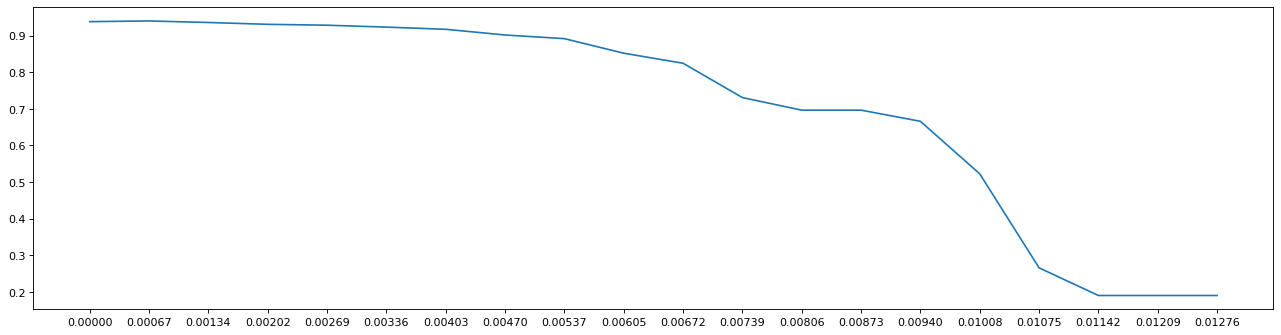

In [20]:
# #======【TIME WARNING：10 mins】======#

# RFC_ .fit(x, y).feature_importances_
threshold = np.linspace(0, (RFC_.fit(x,y).feature_importances_).max(), 20)
score = []
for i in threshold:
    x_embedded = SelectFromModel(RFC_, threshold=i).fit_transform(x, y)
    ret = cross_val_score(RFC_, x_embedded, y, cv=5).mean()
    score.append(ret)
    
plt.figure(figsize=(20,5),dpi=80)
plt.plot(threshold, score)
plt.xticks(threshold)
plt.show()

从图像上来看，随着阈值越来越高，模型的效果逐渐变差，被删除的特征越来越多，信息损失也逐渐变大。但是在
0.00134之前，模型的效果都可以维持在0.93以上，因此我们可以从中挑选一个数值来验证一下模型的效果。

In [22]:
x_embedded = SelectFromModel(RFC_, threshold=0.00067).fit_transform(x, y)
x_embedded.shape

(42000, 324)

In [23]:
cross_val_score(RFC_, x_embedded, y, cv=5).mean()

0.939905083368037

可以看出，特征个数瞬间缩小到324多，这比我们在方差过滤的时候选择中位数过滤出来的结果392列要小，并且交叉验证分数0.9399高于方差过滤后的结果0.9388，这是由于嵌入法比方差过滤更具体到模型的表现的缘故，换一个算法，使用同样的阈值，效果可能就没有这么好了。

和其他调参一样，我们可以在第一条学习曲线后选定一个范围，使用细化的学习曲线来找到最佳值：

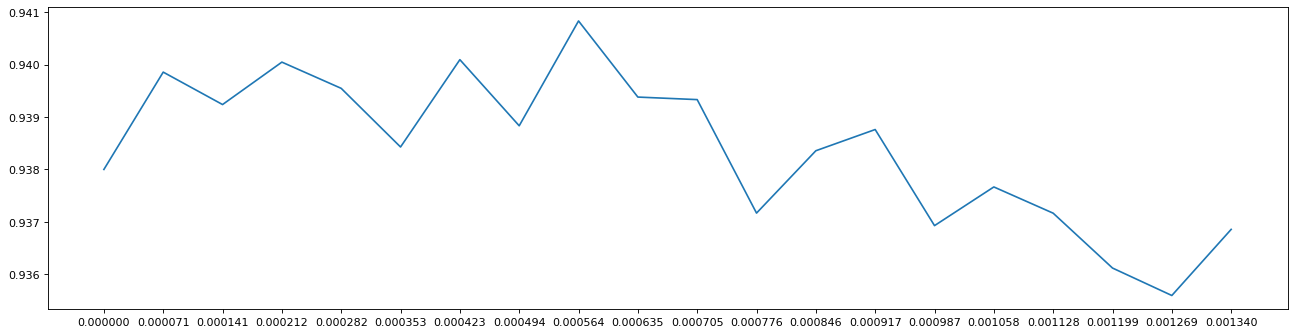

In [29]:
# #======【TIME WARNING：10 mins】======#

score2 = []
for i in  np.linspace(0, 0.00134, 20):
    x_embedded = SelectFromModel(RFC_, threshold=i).fit_transform(x, y)
    ret = cross_val_score(RFC_, x_embedded, y, cv=5).mean()
    score2.append(ret)
    
plt.figure(figsize=(20,5),dpi=80)
plt.plot( np.linspace(0, 0.00134, 20), score2)
plt.xticks( np.linspace(0, 0.00134, 20))
plt.show()

查看结果，果然0.00067并不是最高点，真正的最高点0.000564已经将模型效果提升到了94%以上。我们使用0.000564来跑一跑我们的SelectFromModel：

In [31]:
x_embedded = SelectFromModel(RFC_, threshold=0.000564).fit_transform(x, y)
cross_val_score(RFC_, x_embedded,y, cv=5).mean()

0.9408335415056387

In [34]:
x_embedded.shape

(42000, 340)

In [33]:
# 我们可能已经找到了现有模型下的最佳结果，如果我们调整一下随机森林的参数呢？
cross_val_score(RFC(n_estimators=150,random_state=5),x_embedded,y,cv=5).mean()

0.9643814593387704

得出的特征数目依然小于方差筛选，并且模型的表现也比没有筛选之前更高，已经完全可以和计算一次半小时的KNN相匹敌（KNN的准确率是96.58%），接下来再对随机森林进行调参，准确率应该还可以再升高不少。可见，在嵌入法下，我们很容易就能够实现特征选择的目标：减少计算量，提升模型表现。因此，比起要思考很多统计量的过滤法来说，嵌入法可能是更有效的一种方法。然而，在算法本身很复杂的时候，过滤法的计算远远比嵌入法要快，所以大型数据中，我们还是会优先考虑过滤法。

### 3.3、Wrapper包装法

包装法也是一个特征选择和算法训练同时进行的方法，与嵌入法十分相似，它也是依赖于算法自身的选择，比如coef_属性或feature_importances_属性来完成特征选择。但不同的是，我们往往使用一个目标函数作为黑盒来帮助我们选取特征，而不是自己输入某个评估指标或统计量的阈值。包装法在初始特征集上训练评估器，并且通过coef_属性或通过feature_importances_属性获得每个特征的重要性。然后，从当前的一组特征中修剪最不重要的特征。在修剪的集合上递归地重复该过程，直到最终到达所需数量的要选择的特征。区别于过滤法和嵌入法的一次训练解决所有问题，包装法要使用特征子集进行多次训练，因此它所需要的计算成本是最高的。

![](../imgs/wrapper.png)

注意，在这个图中的“算法”，指的不是我们最终用来导入数据的分类或回归算法（即不是随机森林），而是专业的数据挖掘算法，即我们的目标函数。这些数据挖掘算法的核心功能就是选取最佳特征子集。

最典型的目标函数是递归特征消除法（Recursive feature elimination, 简写为RFE）。它是一种贪婪的优化算法，旨在找到性能最佳的特征子集。 它反复创建模型，并在每次迭代时保留最佳特征或剔除最差特征，下一次迭代时，它会使用上一次建模中没有被选中的特征来构建下一个模型，直到所有特征都耗尽为止。 然后，它根据自己保留或剔除特征的顺序来对特征进行排名，最终选出一个最佳子集。包装法的效果是所有特征选择方法中最利于提升模型表现的，它可以使用很少的特征达到很优秀的效果。除此之外，在特征数目相同时，包装法和嵌入法的效果能够匹敌，不过它比嵌入法算得更见缓慢，所以也不适用于太大型的数据。相比之下，包装法是最能保证模型效果的特征选择方法。

- **feature_selection.RFE**

  `class sklearn.feature_selection.RFE (estimator, n_features_to_select=None, step=1, verbose=0)`
  - 参数
      - estimator：是需要填写的实例化后的评估器
      - n_features_to_select：是想要选择的特征个数
      - step：表示每次迭代中希望移除的特征个数。除此之外
  - 属性
      - .support_：返回所有的特征的是否最后被选中的布尔矩阵
      - .ranking_：返回特征的按数次迭代中综合重要性的排名。
类feature_selection.RFECV会在交叉验证循环中执行RFE以找到最佳数量的特征，增加参数cv，其他用法都和RFE一模一样。

In [36]:
RFC_ = RFC(n_estimators=10, random_state=0)
# n_features_to_select:选择上面嵌入法得到的特征数
selector = RFE(RFC_, n_features_to_select=340, step=50).fit(x, y)

selector.support_.sum()

340

In [41]:
selector.ranking_[:17]

array([10,  9,  8,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6])

In [42]:
x_wrapper = selector.transform(x)
cross_val_score(RFC_, x_wrapper, y, cv=5).mean()  # 相较于嵌入法降低了

0.9389522459432109

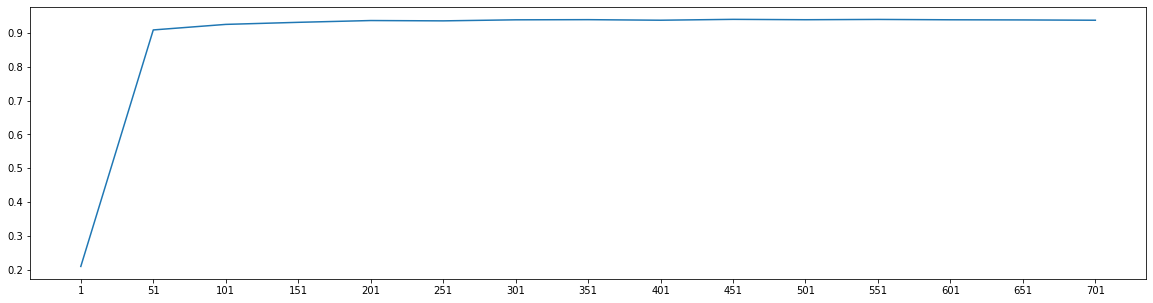

In [44]:
# 对包装法画学习曲线
# ======【TIME WARNING: 15 mins】======#
score = []
for i in range(1, 751, 50):
    x_wrapper = RFE(RFC_, n_features_to_select=i, step=50).fit_transform(x, y)
    once = cross_val_score(RFC_, x_wrapper, y, cv=5).mean()
    score.append(once)

plt.figure(figsize=(20,5))
plt.plot(range(1, 751, 50), score)
plt.xticks(range(1, 751, 50))
plt.show()

明显能够看出，在包装法下面，应用50个特征时，模型的表现就已经达到了90%以上，比嵌入法和过滤法都高效很多。我们可以放大图像，寻找模型变得非常稳定的点来画进一步的学习曲线（就像我们在嵌入法中做的那样）。如果我们此时追求的是最大化降低模型的运行时间，我们甚至可以直接选择50作为特征的数目，这是一个在缩减了94%的特征的基础上，还能保证模型表现在90%以上的特征组合，不可谓不高效。

同时，我们提到过，在特征数目相同时，包装法能够在效果上匹敌嵌入法。试试看如果我们也使用340作为特征数目，运行一下，可以感受一下包装法和嵌入法哪一个的速度更加快。由于包装法效果和嵌入法相差不多，在更小的范围内使用学习曲线，我们也可以将包装法的效果调得很好，可以试试看。

0.93383440758353 170


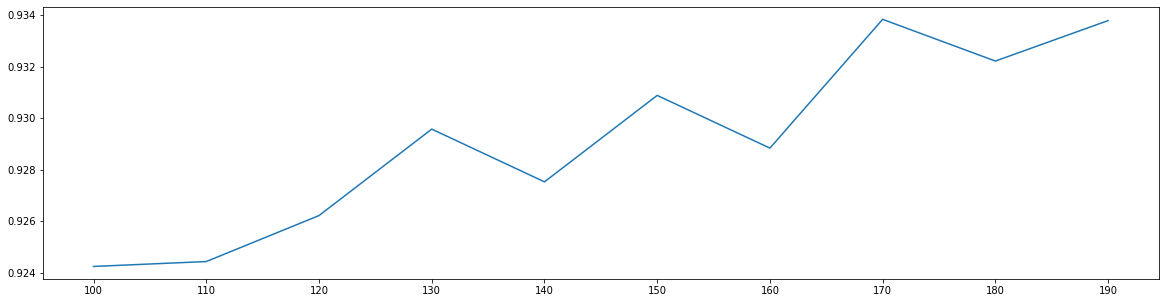

In [50]:
score = []
for i in range(100, 200, 10):
    x_wrapper = RFE(RFC_, n_features_to_select=i, step=50).fit_transform(x, y)
    once = cross_val_score(RFC_, x_wrapper, y, cv=5).mean()
    score.append(once)

print(max(score), range(100, 200, 10)[score.index(max(score))])  
plt.figure(figsize=(20,5))
plt.plot(range(100, 200, 10), score)
plt.xticks(range(100, 200, 10))
plt.show()

### 3.4、特征选择总结

至此，我们讲完了降维之外的所有特征选择的方法。这些方法的代码都不难，但是每种方法的原理都不同，并且都涉及到不同调整方法的超参数。经验来说，过滤法更快速，但更粗糙。包装法和嵌入法更精确，比较适合具体到算法去调整，但计算量比较大，运行时间长。当数据量很大的时候，优先使用方差过滤和互信息法调整，再上其他特征选择方法。使用逻辑回归时，优先使用嵌入法。使用支持向量机时，优先使用包装法。迷茫的时候，从过滤法走起，看具体数据具体分析。

其实特征选择只是特征工程中的第一步。真正的高手，往往使用特征创造或特征提取来寻找高级特征。在Kaggle之类的算法竞赛中，很多高分团队都是在高级特征上做文章，而这是比调参和特征选择更难的，提升算法表现的高深方法。特征工程非常深奥，虽然我们日常可能用到不多，但其实它非常美妙。若大家感兴趣，也可以自己去网上搜一搜，多读多看多试多想，技术逐渐会成为你的囊中之物。